Les pannes machines ont-elles un effet significatif sur les volumes traités ? 

In [60]:
import pandas as pd

df = pd.read_csv("dataset_impact_pannes_010625.csv")
df = df[["temps_arret_panne","nb_pannes_machines","volume_traite"]] # je sélectionne mes 2 variables explicatives puis ma variable cible 
df.head(10)

,temps_arret_panne,nb_pannes_machines,volume_traite
0,0,0,245
1,0,0,290
2,0,0,262
3,0,0,284
4,0,0,263
5,0,0,241
6,0,0,307
7,0,0,254
8,0,0,304
9,0,0,232


In [62]:
df.dtypes

temps_arret_panne     int64
nb_pannes_machines    int64
volume_traite         int64
dtype: object

In [9]:
corr_matrix = df.corr(method='pearson')
print(corr_matrix)

                    temps_arret_panne  nb_pannes_machines  volume_traite
temps_arret_panne            1.000000            0.814489      -0.489967
nb_pannes_machines           0.814489            1.000000      -0.386451
volume_traite               -0.489967           -0.386451       1.000000


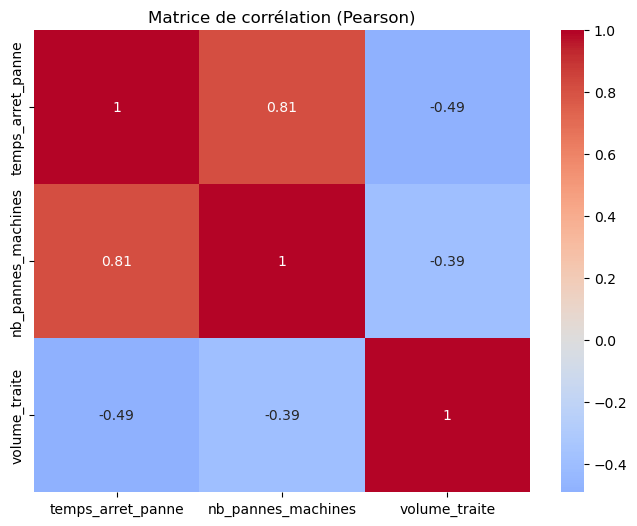

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation (Pearson)')
plt.show()

--------- Interprétation ---------------------------------------

Corrélation intéressante et à noter entre le temps d'arrêt et le volume traité surtout. 
La corrélation est négative, ce qui veut dire qu'au plus le temps d'arrêt augmente au plus faible sera le volume traité (-0,49). 

In [58]:
df.describe()

,temps_arret_panne,nb_pannes_machines,volume_traite
count,19020.000000,19020.000000,19020.000000
mean,8.068244,0.332177,351.283438
std,14.045953,0.471006,228.495742
min,0.000000,0.000000,1.000000
25%,0.000000,0.000000,151.000000
50%,0.000000,0.000000,283.000000
75%,12.000000,1.000000,493.000000
max,48.000000,1.000000,1000.000000


--------- Interprétation ---------------------------------------

Avant de passer à la régression et au machine learning, nous voyons ici que les variables explicatives sont sur des échelles bien différentes. 
Donc, nous passerons par une phase de standardisation (moyenne centrée à 0 et écart-type de 1 sur les 2 variables). 

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

X = df[['temps_arret_panne', 'nb_pannes_machines']]
y = df['volume_traite']

# Je Standardise mes 2 variables explicatives afin de les mettre sur une même échelle de comparaison. 
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle de régression linéaire
model_reg_lin = LinearRegression()
model_reg_lin.fit(X_train, y_train)

# Prédictions
y_pred = model_reg_lin.predict(X_test)

# Évaluation
print("R² :", r2_score(y_test, y_pred))
print("MAE :", mean_absolute_error(y_test, y_pred))
print("Médiane volume_traite :", df["volume_traite"].median())

R² : 0.23227125057465192
MAE : 156.36136358844146
Médiane volume_traite : 283.0


------------ Interprétation ---------------------- 

1/ R2 score à 23 % => score faible, le modèle explique 23% de la variance du volume traité. Ce qui veut dire qu'il existe d'autres facteurs explicatifs. 
2/ MAE à 156 : en moyenne, l'erreur de prédiction est de 156 unités par machine et par mois, ce qui est très élevé comparé à une médiane de 283. 

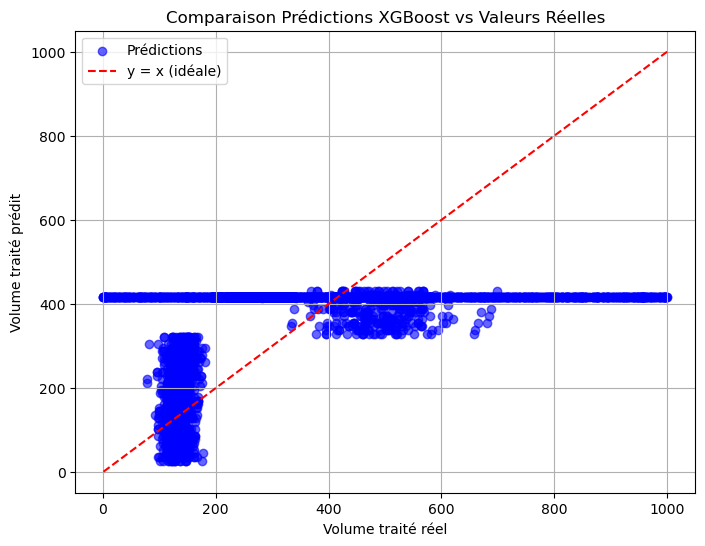

In [54]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))

# Nuage de points : valeurs réelles vs prédictions
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label='Prédictions')

# Droite y = x (référence idéale)
lims = [min(min(y_test), min(y_pred)), max(max(y_test), max(y_pred))]
plt.plot(lims, lims, 'r--', label='y = x (idéale)')

plt.xlabel("Volume traité réel")
plt.ylabel("Volume traité prédit")
plt.title("Comparaison Prédictions XGBoost vs Valeurs Réelles")
plt.legend()
plt.grid(True)
plt.show()

In [56]:
import xgboost as xgb

# Définir et entraîner le modèle XGBoost avec max_depth modifié
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, max_depth=3, n_estimators=100, learning_rate=0.05)
model_xgb.fit(X_train, y_train)

# Prédictions
y_pred = model_xgb.predict(X_test)

# Évaluation
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Résultats
print("R² :", r2)
print("MAE :", mae)
print("Médiane volume_traite :", df["volume_traite"].median())

R² : 0.29476118087768555
MAE : 134.75295914610854
Médiane volume_traite : 283.0


C:\Users\jean-\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [42]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01]
}

model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid = GridSearchCV(model, param_grid=params, scoring='r2', cv=3, verbose=1)
grid.fit(X_train, y_train)

print("Meilleurs paramètres :", grid.best_params_)
print("Meilleur R2 sur validation :", grid.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Meilleurs paramètres : {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Meilleur R2 sur validation : 0.30117589235305786


------------ Interprétation ---------------------- 

R2 score plus élevé que par rapport à la régression linéaire. Donc la variance du nombre d'unités traitées s'explique mieux via le xgboost (après optimisation hyperparamètres via gridsearch) que via la régression linéaire multiple. 
Ce qui reste toutefois un score de r2 faible voire modéré au mieux : 30% de la variance du volume traité s'explique par les 2 variables explicatives du temps de panne et nombre de pannes. Ce qui répond à la question posée, mais il y a sûrement d'autres variables explicatives à aller chercher. 

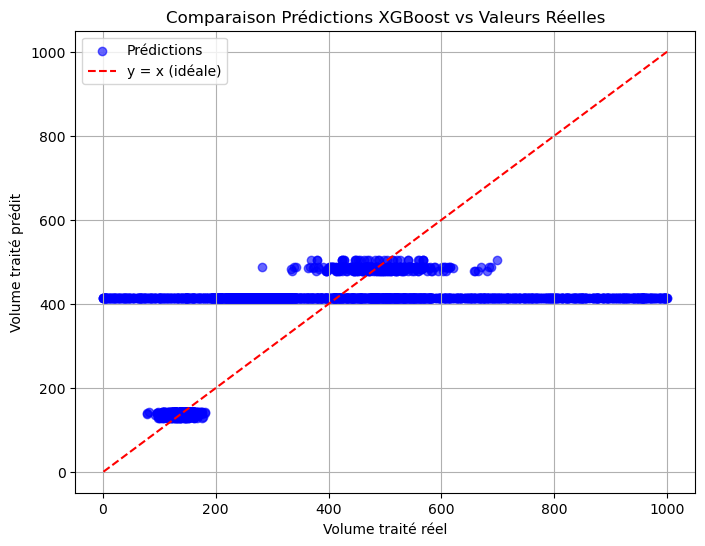

In [44]:
plt.figure(figsize=(8, 6))

# Nuage de points : valeurs réelles vs prédictions
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label='Prédictions')

# Droite y = x (référence idéale)
lims = [min(min(y_test), min(y_pred)), max(max(y_test), max(y_pred))]
plt.plot(lims, lims, 'r--', label='y = x (idéale)')

plt.xlabel("Volume traité réel")
plt.ylabel("Volume traité prédit")
plt.title("Comparaison Prédictions XGBoost vs Valeurs Réelles")
plt.legend()
plt.grid(True)
plt.show()

Je note que le modèle prédit souvent 3 valeurs : 175, 425 et 500 ce qui est le cas même après le jeu sur les hyperparamètres, je suppose que cela vient du dataset (et en particulier, de la pertinence de n'expliquer le volume traité QUE par rapport à ces 2 variables explicatives).
Je trace un graphique sur les données réelles de volume traité, afin d'analyser de plus près. 

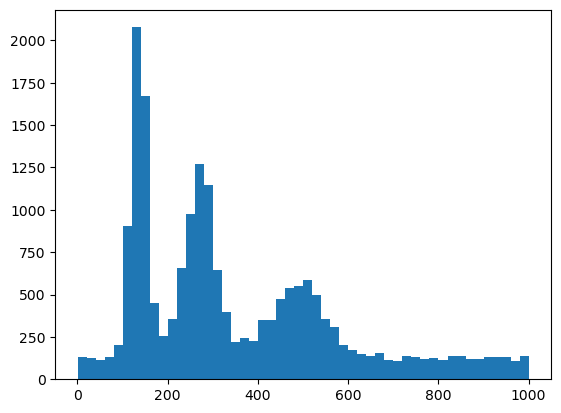

In [48]:
import matplotlib.pyplot as plt
plt.hist(df['volume_traite'], bins=50)
plt.show()

------------------- Interprétation

En effet, le modèle a repéré les 3 pics, et prédit systématiquement autour de ces 3 pics, ce qui peut engendrer les soucis évoqués. 

-------------------- CONCLUSION ------------------------------------------------------------------------------- 

Les pannes machines ont un effet significatif sur les volumes traités. Elles expliquent 29% de la variance dans les volumes traités. C'est un impact négatif : chaque minute de panne et chaque panne supplémentaire, engendrent une réduction du volume traité. 
Cela veut aussi dire, qu'il faudrait intégrer plus de données en entrée en tant que variables explicatives, pour mieux expliquer pourquoi on a des pannes. Et ainsi mieux prédire et réduire les pannes. 